In [1]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Specify the file path
file_path = "C:/Users/maria/OneDrive/Documentos/CS_Clases/Desicion_Modeling/NutriScore_Project/Ahmad_Mayorga-Llano_Khalid.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

In [2]:
# Specify the columns you want to extract
columns_to_extract = [
    "product_name",
    "nutriscore_score",
    "nutriscore_grade",
    "energy-kj_100g",
    "sugars_100g",
    "saturated-fat_100g",
    "salt_100g",
    "proteins_100g",
    "fiber_100g",
    "fruits-vegetables-nuts-estimate-from-ingredients_100g",
]


# Extract the specified columns
selected_columns = df[columns_to_extract]
selected_columns

,product_name,nutriscore_score,nutriscore_grade,energy-kj_100g,sugars_100g,saturated-fat_100g,salt_100g,proteins_100g,fiber_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,Multigrano arandanos y sabor fresa,11.0,d,1940.0,29.4,4.41,0.411,5.88,5.88,15.000000
1,Les gourmandises chocolat noir et fruits - Fra...,21.0,e,1958.0,60.0,13.00,0.020,3.30,4.60,23.000000
2,Tortilla Chips - Salted,1.0,b,1979.0,0.8,2.00,0.900,6.60,4.00,0.000000
3,Stevia chocolate,14.0,d,1741.1,14.4,20.20,0.300,11.30,10.20,0.000000
4,Il Pandoro,19.0,e,1695.0,18.0,12.00,0.650,8.40,1.60,0.000000
...,...,...,...,...,...,...,...,...,...,...
305,Génoises Orange,17.0,d,1610.0,52.0,6.00,0.150,3.00,2.00,11.000000
306,Chocolat au lait du Pays Alpin,25.0,e,2210.0,59.0,18.00,0.000,6.10,1.80,0.390625
307,Soßenkuchen,3.0,c,1507.0,29.0,0.20,0.050,7.90,2.90,0.000000
308,Soufflé à la cacahuète,19.0,e,2039.0,1.8,7.40,1.430,10.50,0.00,19.000000


In [3]:
#Initialize variables
lambda_thresholds_percentage = [0.5,0.6, 0.7] 
weights = [1,1,1,1,2,2,2]
preference_thresholds_pi = [
    [3350, 34, 10, 2, 2.4, 3, 40 ], # pi_1
    [2345, 23.8, 7, 1.4,7.26, 4.46, 53.3 ], # pi_2
    [1340, 13.6, 4, 0.8, 12.13, 5.93, 66.6], # pi_3
    [335, 3.4, 1, 0.2, 17, 7.4, 80] # pi_4
]

In [4]:
#Get the sum of weights of the item if it surpases the pi threshold
def item_assessment(weights, item_criterias, preference_thresholds_pi):
    
    
    #Adjust weights to be percentage-wise
    adjusted_weights = [weight / sum(weights) for weight in weights]
    #print(adjusted_weights)

    if len(weights) != len(preference_thresholds_pi) or len(item_criterias) != len(preference_thresholds_pi):
        #print(len(weights), len(criteria), len(preference_thresholds_pi))
        raise ValueError("Input lists must have the same length.")

    assessments = [adjusted_weight if item_value >= threshold else 0 for adjusted_weight, item_value, threshold in zip(adjusted_weights, item_criterias, preference_thresholds_pi)]
    #print("Pi", preference_thresholds_pi)
    #print("ITEM CRITERIA", item_criterias)
    #print("Weights", adjusted_weights)
    #print("Assessments", assessments)
    total_assessment = sum(assessments)
    return total_assessment


In [5]:
def item_assessment(weights, item_criterias, preference_thresholds_pi, positive_characteristics=None, negative_characteristics=None):
    # Default positive characteristics
    if positive_characteristics is None:
        positive_characteristics = ["proteins_100g", "fiber_100g", "fruits-vegetables-nuts-estimate-from-ingredients_100g"]

    # Default negative characteristics
    if negative_characteristics is None:
        negative_characteristics = ["energy-kj_100g", "sugars_100g", "saturated-fat_100g", "salt_100g"]

    # Adjust weights to be percentage-wise
    adjusted_weights = [weight / sum(weights) for weight in weights]

    # Check if input lists have the same length
    if len(weights) != len(preference_thresholds_pi) or len(item_criterias) != len(preference_thresholds_pi):
        raise ValueError("Input lists must have the same length.")

    # Assess positive characteristics (unchanged threshold comparison)
    positive_assessments = [
        adjusted_weight if feature in positive_characteristics and value >= threshold else 0
        for adjusted_weight, feature, value, threshold in zip(adjusted_weights, item_criterias.index, item_criterias, preference_thresholds_pi)
    ]

    # Assess negative characteristics (modified threshold comparison)
    negative_assessments = [
        adjusted_weight if feature in negative_characteristics and value <= threshold else 0
        for adjusted_weight, feature, value, threshold in zip(adjusted_weights, item_criterias.index, item_criterias, preference_thresholds_pi)
    ]

    # Combine positive and negative assessments
    combined_assessments = [pos + neg for pos, neg in zip(positive_assessments, negative_assessments)]

    total_assessment = sum(combined_assessments)
    
    #print("Positive Assessments:", positive_assessments, "Negative Assessments:", negative_assessments, "Combined Assessments:", combined_assessments)

    return total_assessment


In [6]:
#Testing variables
# Specify the columns you want to extract
columns_to_test = [
    "energy-kj_100g",
    "sugars_100g",
    "saturated-fat_100g",
    "salt_100g",
    "proteins_100g",
    "fiber_100g",
    "fruits-vegetables-nuts-estimate-from-ingredients_100g",
]


# Extract the specified columns
testing_columns = df[columns_to_test]
testing_columns

testing_weights = [0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0]
testing_item = testing_columns.iloc[0].copy()
testing_pi = [2345, 23.8, 7, 1.4, 8, 2, 15]

testing_item

energy-kj_100g                                           1940.000
sugars_100g                                                29.400
saturated-fat_100g                                          4.410
salt_100g                                                   0.411
proteins_100g                                               5.880
fiber_100g                                                  5.880
fruits-vegetables-nuts-estimate-from-ingredients_100g      15.000
Name: 0, dtype: float64

In [7]:
item_assessment(testing_weights, testing_item, testing_pi)

0.7

In [8]:
def matrix_assessment(weights, df, preference_thresholds_pi, positive_characteristics=None, negative_characteristics=None):
    # Extract items characteristics
    # If positive_characteristics and negative_characteristics are provided, use their union
    if positive_characteristics is not None and negative_characteristics is not None:
        columns_criterias = list(set(positive_characteristics) | set(negative_characteristics))
    else:
        # Default list of columns
        columns_criterias = [
            "energy-kj_100g",
            "sugars_100g",
            "saturated-fat_100g",
            "salt_100g",
            "proteins_100g",
            "fiber_100g",
            "fruits-vegetables-nuts-estimate-from-ingredients_100g",
        ]

    criterias = df[columns_criterias]

    # Iterate over each list of preference thresholds
    for i, thresholds in enumerate(preference_thresholds_pi, start=1):
        # List to store the results
        assessment_results = []

        # Iterate over each row in the DataFrame
        for index, row in criterias.iterrows():
            # Apply item_assessment to the current row
            result = item_assessment(weights, row, thresholds, positive_characteristics, negative_characteristics)

            # Append the result to the list
            assessment_results.append(result)

        # Add a new column to the DataFrame for each set of thresholds
        df[f'assessment_pi_{i}'] = assessment_results

    return df

# Call the function with the DataFrame and list of lists
result_df = matrix_assessment(weights, selected_columns, preference_thresholds_pi)

# Display the resulting DataFrame
result_df


C:\Users\maria\AppData\Local\Temp\ipykernel_6612\1438688006.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'assessment_pi_{i}'] = assessment_results
C:\Users\maria\AppData\Local\Temp\ipykernel_6612\1438688006.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'assessment_pi_{i}'] = assessment_results
C:\Users\maria\AppData\Local\Temp\ipykernel_6612\1438688006.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,product_name,nutriscore_score,nutriscore_grade,energy-kj_100g,sugars_100g,saturated-fat_100g,salt_100g,proteins_100g,fiber_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,assessment_pi_1,assessment_pi_2,assessment_pi_3,assessment_pi_4
0,Multigrano arandanos y sabor fresa,11.0,d,1940.0,29.4,4.41,0.411,5.88,5.88,15.000000,0.8,0.5,0.1,0.0
1,Les gourmandises chocolat noir et fruits - Fra...,21.0,e,1958.0,60.0,13.00,0.020,3.30,4.60,23.000000,0.6,0.4,0.1,0.1
2,Tortilla Chips - Salted,1.0,b,1979.0,0.8,2.00,0.900,6.60,4.00,0.000000,0.8,0.4,0.2,0.1
3,Stevia chocolate,14.0,d,1741.1,14.4,20.20,0.300,11.30,10.20,0.000000,0.7,0.7,0.3,0.2
4,Il Pandoro,19.0,e,1695.0,18.0,12.00,0.650,8.40,1.60,0.000000,0.5,0.5,0.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,Génoises Orange,17.0,d,1610.0,52.0,6.00,0.150,3.00,2.00,11.000000,0.5,0.3,0.1,0.1
306,Chocolat au lait du Pays Alpin,25.0,e,2210.0,59.0,18.00,0.000,6.10,1.80,0.390625,0.4,0.2,0.1,0.1
307,Soßenkuchen,3.0,c,1507.0,29.0,0.20,0.050,7.90,2.90,0.000000,0.6,0.5,0.2,0.2
308,Soufflé à la cacahuète,19.0,e,2039.0,1.8,7.40,1.430,10.50,0.00,19.000000,0.6,0.4,0.1,0.1


In [9]:
def PessimisticmajoritySorting(weights, lambda_thresholds, selected_columns, preference_thresholds_pi, positive_characteristics=None, negative_characteristics=None):
    #gano gano pierdo paro
    
    assessed_items = matrix_assessment(weights, selected_columns, preference_thresholds_pi, positive_characteristics, negative_characteristics)
    # Iterate over each lambda threshold
    for lambda_threshold in lambda_thresholds_percentage:
        # Create a list to store the classes
        class_list = []

        # Iterate over each row in the DataFrame
        for index, row in assessed_items.iterrows():
            # Check the conditions and assign the corresponding class
            if row['assessment_pi_4'] > lambda_threshold:
                classification = 'a'
            elif row['assessment_pi_3'] > lambda_threshold:
                classification = 'b'
            elif row['assessment_pi_2'] > lambda_threshold:
                classification = 'c'
            elif row['assessment_pi_1'] > lambda_threshold:
                classification = 'd'
            else:
                classification = 'e'

            # Append the class to the list
            class_list.append(classification)

            # Add a new column with a name based on the current lambda threshold
            column_name = f'Pes_classification_{int(lambda_threshold * 100)}'
        
        assessed_items[column_name] = class_list
        
    return assessed_items

PessimisticmajoritySorting(weights, lambda_thresholds_percentage, selected_columns, preference_thresholds_pi)

C:\Users\maria\AppData\Local\Temp\ipykernel_6612\1438688006.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'assessment_pi_{i}'] = assessment_results


,product_name,nutriscore_score,nutriscore_grade,energy-kj_100g,sugars_100g,saturated-fat_100g,salt_100g,proteins_100g,fiber_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,assessment_pi_1,assessment_pi_2,assessment_pi_3,assessment_pi_4,Pes_classification_50,Pes_classification_60,Pes_classification_70
0,Multigrano arandanos y sabor fresa,11.0,d,1940.0,29.4,4.41,0.411,5.88,5.88,15.000000,0.8,0.5,0.1,0.0,d,d,d
1,Les gourmandises chocolat noir et fruits - Fra...,21.0,e,1958.0,60.0,13.00,0.020,3.30,4.60,23.000000,0.6,0.4,0.1,0.1,d,d,e
2,Tortilla Chips - Salted,1.0,b,1979.0,0.8,2.00,0.900,6.60,4.00,0.000000,0.8,0.4,0.2,0.1,d,d,d
3,Stevia chocolate,14.0,d,1741.1,14.4,20.20,0.300,11.30,10.20,0.000000,0.7,0.7,0.3,0.2,c,c,e
4,Il Pandoro,19.0,e,1695.0,18.0,12.00,0.650,8.40,1.60,0.000000,0.5,0.5,0.1,0.0,e,e,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,Génoises Orange,17.0,d,1610.0,52.0,6.00,0.150,3.00,2.00,11.000000,0.5,0.3,0.1,0.1,e,e,e
306,Chocolat au lait du Pays Alpin,25.0,e,2210.0,59.0,18.00,0.000,6.10,1.80,0.390625,0.4,0.2,0.1,0.1,e,e,e
307,Soßenkuchen,3.0,c,1507.0,29.0,0.20,0.050,7.90,2.90,0.000000,0.6,0.5,0.2,0.2,d,d,e
308,Soufflé à la cacahuète,19.0,e,2039.0,1.8,7.40,1.430,10.50,0.00,19.000000,0.6,0.4,0.1,0.1,d,d,e


In [36]:
def OptimisticmajoritySorting(weights, lambda_thresholds, selected_columns, preference_thresholds_pi, positive_characteristics=None, negative_characteristics=None):
    #pierdo pierdo gano paro
    assessed_items = matrix_assessment(weights, selected_columns, preference_thresholds_pi, positive_characteristics, negative_characteristics)

    # Iterate over each lambda threshold
    for lambda_threshold in lambda_thresholds_percentage:
        # Create a list to store the classes
        class_list = []

        # Iterate over each row in the DataFrame
        for index, row in assessed_items.iterrows():
            # Check the conditions and assign the corresponding class
            if row['assessment_pi_1'] < lambda_threshold:
                classification = 'e'
            elif row['assessment_pi_2'] < lambda_threshold:
                classification = 'd'
            elif row['assessment_pi_3'] < lambda_threshold:
                classification = 'c'
            elif row['assessment_pi_4'] < lambda_threshold:
                classification = 'b'
            else:
                classification = 'a'

            # Append the class to the list
            class_list.append(classification)

            # Add a new column with a name based on the current lambda threshold
            column_name = f'Opt_classification_{int(lambda_threshold * 100)}'
        
        assessed_items[column_name] = class_list
        
    return assessed_items


result = OptimisticmajoritySorting(weights, lambda_thresholds_percentage, selected_columns, preference_thresholds_pi)
result

result.to_excel("C:/Users/maria/OneDrive/Documentos/CS_Clases/Desicion_Modeling/NutriScore_Project/MAK-Classification_results.xlsx", index=False)

<Figure size 864x576 with 0 Axes>

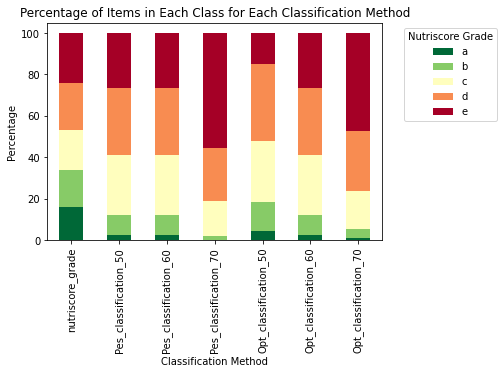

In [11]:
# Select relevant columns
class_columns = ['nutriscore_grade', 'Pes_classification_50', 'Pes_classification_60', 'Pes_classification_70', 'Opt_classification_50', 'Opt_classification_60', 'Opt_classification_70']

# Calculate the percentage of items in each class for each classification method
class_percentages = result[class_columns].apply(lambda x: x.value_counts(normalize=True) * 100)

# Plot the stacked bar plot
plt.figure(figsize=(12, 8))
class_percentages.T.plot(kind='bar', stacked=True, colormap='RdYlGn_r')
plt.title('Percentage of Items in Each Class for Each Classification Method')
plt.xlabel('Classification Method')
plt.ylabel('Percentage')
plt.legend(title='Nutriscore Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


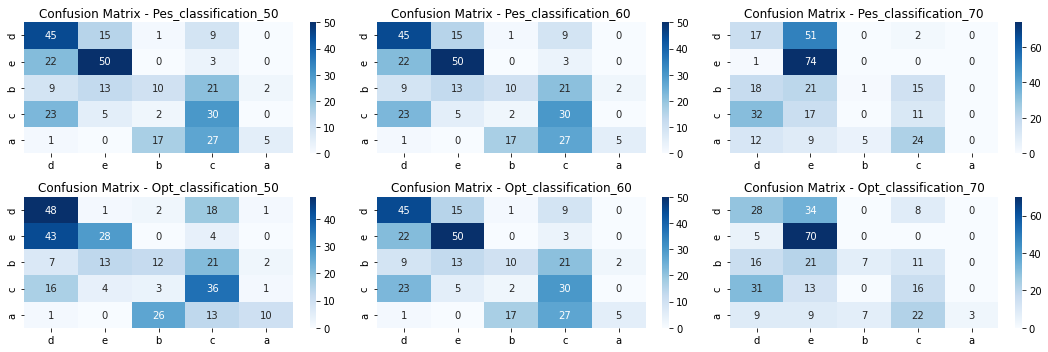

In [12]:

# Assuming 'result' is your DataFrame
# Extract relevant columns
class_columns = ['nutriscore_grade', 'Pes_classification_50', 'Pes_classification_60', 'Pes_classification_70',
                 'Opt_classification_50', 'Opt_classification_60', 'Opt_classification_70']


# Confusion matrix analysis
confusion_matrices = {}
for col in class_columns[1:]:
    cm = confusion_matrix(result['nutriscore_grade'], result[col], labels=result['nutriscore_grade'].unique())
    confusion_matrices[col] = cm

# Visualizations
plt.figure(figsize=(15, 5))

# Confusion Matrix Heatmaps
plt.subplot(1, 3, 3)
for idx, (col, cm) in enumerate(confusion_matrices.items(), start=1):
    plt.subplot(2, 3, idx)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=result['nutriscore_grade'].unique(),
                yticklabels=result['nutriscore_grade'].unique())
    plt.title(f'Confusion Matrix - {col}')

plt.tight_layout()
plt.show()

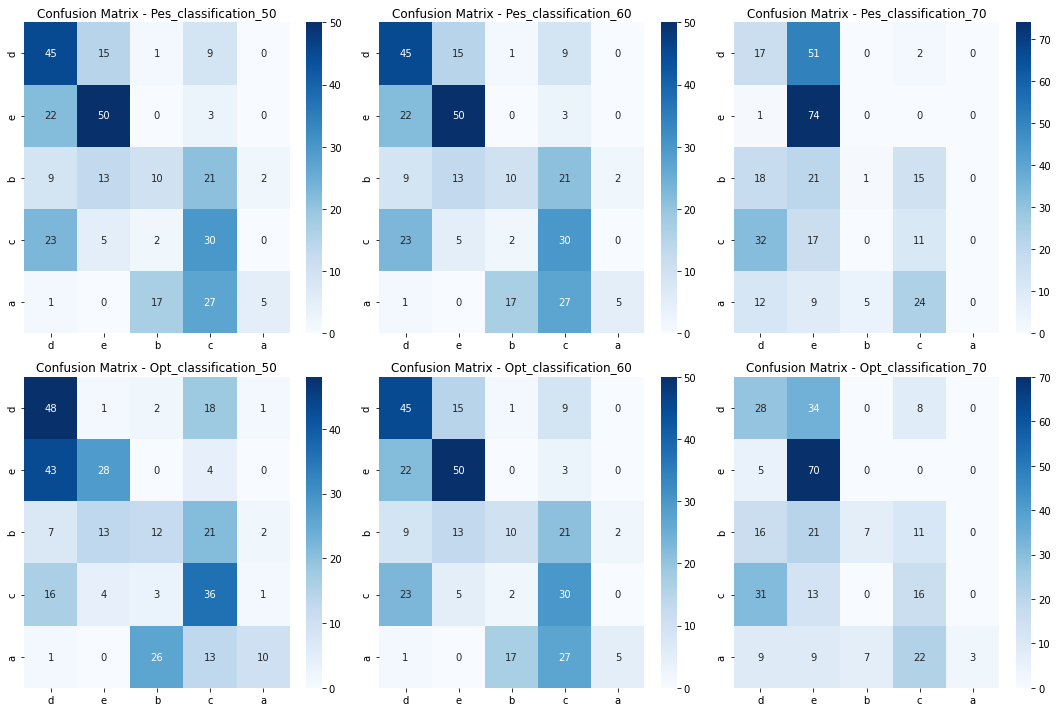

In [13]:


# Assuming 'result' is your DataFrame
class_columns = ['nutriscore_grade', 'Pes_classification_50', 'Pes_classification_60', 'Pes_classification_70',
                 'Opt_classification_50', 'Opt_classification_60', 'Opt_classification_70']

# Confusion matrix analysis
confusion_matrices = {}
for col in class_columns[1:]:
    cm = confusion_matrix(result['nutriscore_grade'], result[col], labels=result['nutriscore_grade'].unique())
    confusion_matrices[col] = cm

# Plotting confusion matrices
plt.figure(figsize=(15, 10))
for idx, (col, cm) in enumerate(confusion_matrices.items(), start=1):
    plt.subplot(2, 3, idx)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=result['nutriscore_grade'].unique(),
                yticklabels=result['nutriscore_grade'].unique())
    plt.title(f'Confusion Matrix - {col}')

plt.tight_layout()
plt.show()


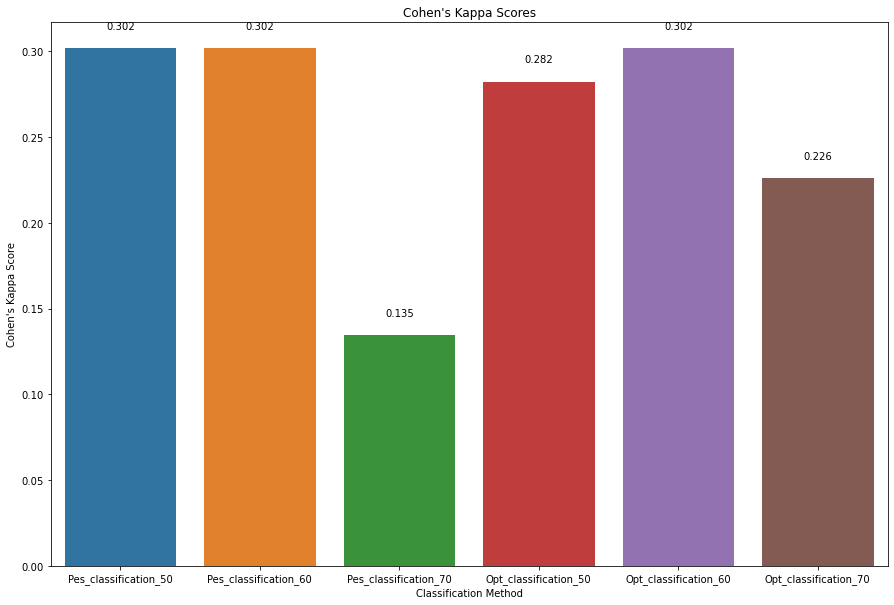

In [14]:
# Cohen's Kappa Scores Bar Chart
# Cohen's Kappa
# Select relevant columns
class_columns = ['nutriscore_grade', 'Pes_classification_50', 'Pes_classification_60', 'Pes_classification_70', 'Opt_classification_50', 'Opt_classification_60', 'Opt_classification_70']

# Cohen's Kappa
kappa_scores = {}
for col in class_columns[1:]:
    kappa = cohen_kappa_score(result['nutriscore_grade'], result[col])
    kappa_scores[col] = kappa

# Plot with numeric values
plt.figure(figsize=(15, 10))
ax = sns.barplot(x=list(kappa_scores.keys()), y=list(kappa_scores.values()))

# Add numeric values to each bar
for i, v in enumerate(kappa_scores.values()):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.title("Cohen's Kappa Scores")
plt.xlabel('Classification Method')
plt.ylabel("Cohen's Kappa Score")
plt.show()

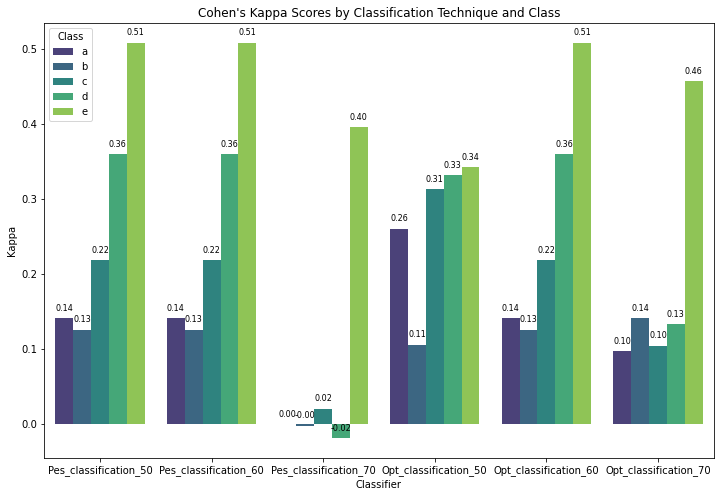

In [80]:
# Assuming you have a DataFrame named 'result' with relevant columns
# Columns: ['nutriscore_grade', 'Pes_classification_50', 'Pes_classification_60', 'Pes_classification_70', 'Opt_classification_50', 'Opt_classification_60', 'Opt_classification_70']
# List of classification techniques
classifiers = ['Pes_classification_50', 'Pes_classification_60', 'Pes_classification_70', 'Opt_classification_50', 'Opt_classification_60', 'Opt_classification_70']

# Initialize an empty dictionary to store Kappa scores
kappa_scores = {'Classifier': [], 'Class': [], 'Kappa': []}

# Iterate over classifiers and calculate Kappa for each class
for classifier in classifiers:
    for nutriscore_class in sorted('abcde'):  # Sort classes alphabetically
        actual = result['nutriscore_grade'] == nutriscore_class
        predicted = result[classifier] == nutriscore_class
        kappa = cohen_kappa_score(actual, predicted)
        kappa_scores['Classifier'].append(classifier)
        kappa_scores['Class'].append(nutriscore_class)
        kappa_scores['Kappa'].append(kappa)

# Create a DataFrame from the dictionary
kappa_df = pd.DataFrame(kappa_scores)

# Plot using seaborn
plt.figure(figsize=(12, 8))
plot = sns.barplot(x='Classifier', y='Kappa', hue='Class', data=kappa_df, palette='viridis')
plt.title("Cohen's Kappa Scores by Classification Technique and Class")

# Add labels to the bars
for p in plot.patches:
    plot.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.show()


# Comparison with another Team

In [61]:
# Specify the file path
gega_file_path = "C:/Users/maria/OneDrive/Documentos/CS_Clases/Desicion_Modeling/NutriScore_Project/Gega-Lorencio_Abril.csv"

# Read the CSV file into a pandas DataFrame
Gega_df = pd.read_csv(gega_file_path)
Gega_df 

,id,name,nutriscore,energy,fat_g,sugar_g,sodium_mg,perc_fruit,fibers_g,proteins_g,...,G_0,PMS_0.5,PMS_0.6,PMS_0.7,OMS_0.5,OMS_0.6,OMS_0.7,Decision Tree,kNN,Random Forest
0,3.16893E+12,Cruesli Mélange De Noix,a,1933.008,19.0,12.0,0.0,0.0,10.0,8.5,...,b,a,b,c,a,c,d,c,e,a
1,80135463,NaN,e,2255.176,30.9,56.3,42.8,0.0,0.0,6.3,...,e,e,e,e,e,e,e,e,e,e
2,20267605,Anacardi,b,2510.400,47.6,6.5,8.0,0.0,5.2,20.5,...,b,a,a,d,a,b,e,b,b,d
3,5.41119E+12,Almonddrink,b,54.392,1.1,0.0,56.0,0.0,0.3,0.4,...,c,e,e,e,e,e,e,b,b,b
4,3.16893E+12,Flocons d'avoine complète,a,1569.000,8.0,1.1,4.0,0.0,9.0,11.0,...,b,a,a,c,a,a,d,a,a,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,20245726,Pommes Rouges,a,213.384,0.5,11.6,4.0,0.0,1.2,0.6,...,c,e,e,e,e,e,e,a,a,a
189,20809669,Schupfnudeln svana,b,769.856,2.0,6.0,384.0,0.0,3.2,6.0,...,b,b,c,c,c,d,d,a,b,a
190,5.20239E+12,Prosociano Bloc,e,1167.336,17.0,0.3,1400.0,0.0,0.0,1.6,...,e,e,e,e,e,e,e,d,c,e
191,8.71469E+12,Bio Houmous,b,866.088,14.9,0.5,360.0,0.0,0.0,7.6,...,c,c,e,e,d,e,e,b,b,b


In [62]:
reordered = ["id", "name", "nutriscore","energy","sugar_g","fat_g","sodium_mg", "proteins_g", "fibers_g", "perc_fruit", "PMS_0.5","PMS_0.6","PMS_0.7","OMS_0.5","OMS_0.6","OMS_0.7"]
Gega_df = Gega_df[reordered]
Gega_df

,id,name,nutriscore,energy,sugar_g,fat_g,sodium_mg,proteins_g,fibers_g,perc_fruit,PMS_0.5,PMS_0.6,PMS_0.7,OMS_0.5,OMS_0.6,OMS_0.7
0,3.16893E+12,Cruesli Mélange De Noix,a,1933.008,12.0,19.0,0.0,8.5,10.0,0.0,a,b,c,a,c,d
1,80135463,NaN,e,2255.176,56.3,30.9,42.8,6.3,0.0,0.0,e,e,e,e,e,e
2,20267605,Anacardi,b,2510.400,6.5,47.6,8.0,20.5,5.2,0.0,a,a,d,a,b,e
3,5.41119E+12,Almonddrink,b,54.392,0.0,1.1,56.0,0.4,0.3,0.0,e,e,e,e,e,e
4,3.16893E+12,Flocons d'avoine complète,a,1569.000,1.1,8.0,4.0,11.0,9.0,0.0,a,a,c,a,a,d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,20245726,Pommes Rouges,a,213.384,11.6,0.5,4.0,0.6,1.2,0.0,e,e,e,e,e,e
189,20809669,Schupfnudeln svana,b,769.856,6.0,2.0,384.0,6.0,3.2,0.0,b,c,c,c,d,d
190,5.20239E+12,Prosociano Bloc,e,1167.336,0.3,17.0,1400.0,1.6,0.0,0.0,e,e,e,e,e,e
191,8.71469E+12,Bio Houmous,b,866.088,0.5,14.9,360.0,7.6,0.0,0.0,c,e,e,d,e,e


In [70]:
positive_characteristics=["proteins_g", "fibers_g", "perc_fruit"]
negative_characteristics=["energy","sugar_g","fat_g","sodium_mg"]
gega_result = PessimisticmajoritySorting(weights, lambda_thresholds_percentage, Gega_df, preference_thresholds_pi, positive_characteristics, negative_characteristics)
gega_result = OptimisticmajoritySorting(weights, lambda_thresholds_percentage, Gega_df, preference_thresholds_pi, positive_characteristics, negative_characteristics)

gega_result_cleaned = gega_result.dropna()
# Select relevant columns
class_columns = ['nutriscore', 'Pes_classification_50', "PMS_0.5",'Pes_classification_60',"PMS_0.6",'Pes_classification_70', "PMS_0.7",'Opt_classification_50', "OMS_0.5",'Opt_classification_60', "OMS_0.6",'Opt_classification_70',"OMS_0.7" ]

gega_result_cleaned = gega_result_cleaned[class_columns]
gega_result_cleaned


,nutriscore,Pes_classification_50,PMS_0.5,Pes_classification_60,PMS_0.6,Pes_classification_70,PMS_0.7,Opt_classification_50,OMS_0.5,Opt_classification_60,OMS_0.6,Opt_classification_70,OMS_0.7
0,a,c,a,c,b,e,c,c,a,c,c,e,d
2,b,a,a,a,a,e,d,a,a,e,b,e,e
3,b,e,e,e,e,e,e,e,e,e,e,e,e
4,a,c,a,c,a,e,c,b,a,c,a,c,d
5,b,d,c,d,c,e,c,d,d,d,d,d,d
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,a,d,b,d,b,e,e,d,c,d,c,e,e
188,a,e,e,e,e,e,e,e,e,e,e,e,e
189,b,d,b,d,c,e,c,c,c,d,d,d,d
190,e,e,e,e,e,e,e,e,e,e,e,e,e


In [71]:
# Assuming df is your DataFrame
gega_result_cleaned.to_excel("C:/Users/maria/OneDrive/Documentos/CS_Clases/Desicion_Modeling/NutriScore_Project/MAK-Classification_GL-dataset.xlsx", index=False)

<Figure size 864x576 with 0 Axes>

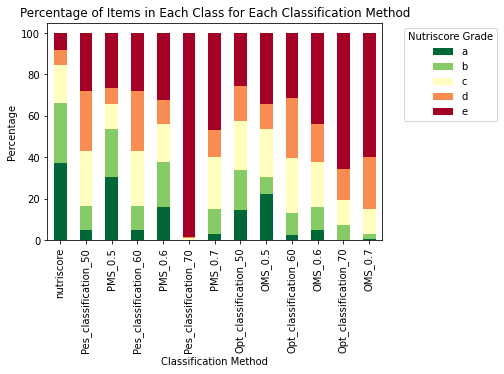

In [72]:

# Calculate the percentage of items in each class for each classification method
class_percentages = gega_result_cleaned.apply(lambda x: x.value_counts(normalize=True) * 100)

# Plot the stacked bar plot
plt.figure(figsize=(12, 8))
class_percentages.T.plot(kind='bar', stacked=True, colormap='RdYlGn_r')
plt.title('Percentage of Items in Each Class for Each Classification Method')
plt.xlabel('Classification Method')
plt.ylabel('Percentage')
plt.legend(title='Nutriscore Grade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

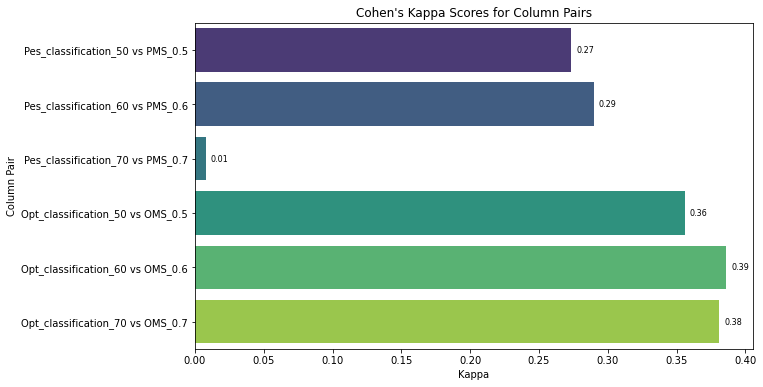

In [88]:
# List of column pairs
column_pairs = [
    ('Pes_classification_50', 'PMS_0.5'),
    ('Pes_classification_60', 'PMS_0.6'),
    ('Pes_classification_70', 'PMS_0.7'),
    ('Opt_classification_50', 'OMS_0.5'),
    ('Opt_classification_60', 'OMS_0.6'),
    ('Opt_classification_70', 'OMS_0.7'),
]

# Initialize an empty dictionary to store Kappa scores
kappa_scores = {'Column Pair': [], 'Kappa': []}

# Iterate over column pairs and calculate Kappa scores
for pair in column_pairs:
    actual = gega_result_cleaned[pair[0]]
    predicted = gega_result_cleaned[pair[1]]
    kappa = cohen_kappa_score(actual, predicted)
    kappa_scores['Column Pair'].append(f'{pair[0]} vs {pair[1]}')
    kappa_scores['Kappa'].append(kappa)
    
# Create a DataFrame from the dictionary
kappa_df = pd.DataFrame(kappa_scores)

# Plot using seaborn
plt.figure(figsize=(10, 6))
plot = sns.barplot(x='Kappa', y='Column Pair', data=kappa_df, palette='viridis')
plt.title("Cohen's Kappa Scores for Column Pairs")

# Add labels to the bars
for p, value in zip(plot.patches, kappa_df['Kappa']):
    plot.annotate(f'{value:.2f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                  ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=8)

plt.show()


In [89]:
kappa_df

,Column Pair,Kappa
0,Pes_classification_50 vs PMS_0.5,0.273387
1,Pes_classification_60 vs PMS_0.6,0.289814
2,Pes_classification_70 vs PMS_0.7,0.007993
3,Opt_classification_50 vs OMS_0.5,0.355972
4,Opt_classification_60 vs OMS_0.6,0.386111
5,Opt_classification_70 vs OMS_0.7,0.381060


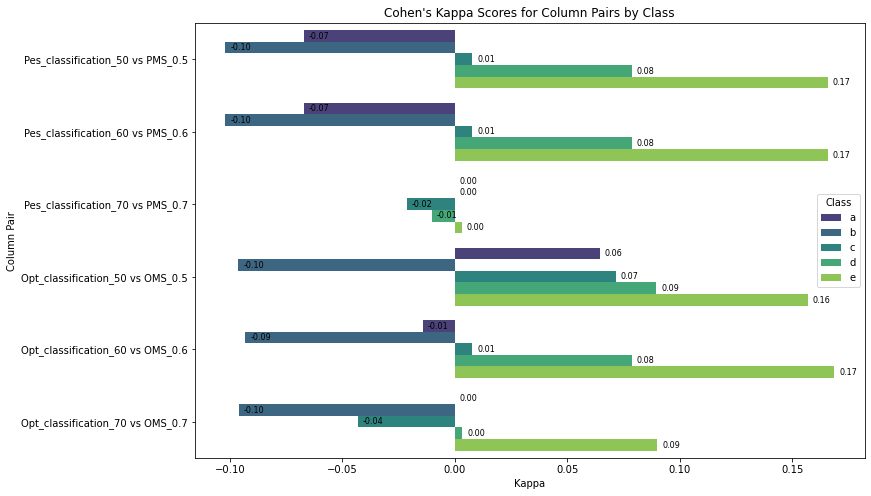

In [91]:
# List of column pairs
column_pairs = [
    ('Pes_classification_50', 'PMS_0.5'),
    ('Pes_classification_60', 'PMS_0.6'),
    ('Pes_classification_70', 'PMS_0.7'),
    ('Opt_classification_50', 'OMS_0.5'),
    ('Opt_classification_60', 'OMS_0.6'),
    ('Opt_classification_70', 'OMS_0.7'),
]

# Initialize an empty dictionary to store Kappa scores
kappa_scores = {'Column Pair': [], 'Class': [], 'Kappa': []}

# Iterate over column pairs and calculate Kappa scores for each class
for pair in column_pairs:
    for nutriscore_class in sorted('abcde'):  # Sort classes alphabetically
        actual = gega_result_cleaned['nutriscore'] == nutriscore_class
        predicted = gega_result_cleaned[pair[0]] == nutriscore_class
        kappa = cohen_kappa_score(actual, predicted)
        kappa_scores['Column Pair'].append(f'{pair[0]} vs {pair[1]}')
        kappa_scores['Class'].append(nutriscore_class)
        kappa_scores['Kappa'].append(kappa)

# Create a DataFrame from the dictionary
kappa_df = pd.DataFrame(kappa_scores)

# Plot using seaborn
plt.figure(figsize=(12, 8))
plot = sns.barplot(x='Kappa', y='Column Pair', hue='Class', data=kappa_df, palette='viridis')
plt.title("Cohen's Kappa Scores for Column Pairs by Class")

# Add labels to the bars
for p in plot.patches:
    plot.annotate(f'{p.get_width():.2f}', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                  ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=8)

plt.show()


In [92]:
kappa_df

,Column Pair,Class,Kappa
0,Pes_classification_50 vs PMS_0.5,a,-0.067251
1,Pes_classification_50 vs PMS_0.5,b,-0.102077
2,Pes_classification_50 vs PMS_0.5,c,0.007831
3,Pes_classification_50 vs PMS_0.5,d,0.078748
4,Pes_classification_50 vs PMS_0.5,e,0.165899
5,Pes_classification_60 vs PMS_0.6,a,-0.067251
6,Pes_classification_60 vs PMS_0.6,b,-0.102077
7,Pes_classification_60 vs PMS_0.6,c,0.007831
8,Pes_classification_60 vs PMS_0.6,d,0.078748
9,Pes_classification_60 vs PMS_0.6,e,0.165899
